# 1. Setup, Install & Imports

In [17]:
# Install required libraries FIRST
!pip install --quiet yfinance statsmodels backtrader

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import itertools
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import yfinance as yf
import backtrader as bt
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import coint

# ---- Base project directory ----
BASE_DIR = "/content/drive/MyDrive/stat_arb_pairs"

DATA_DIR_RAW = os.path.join(BASE_DIR, "data", "raw")
DATA_DIR_CLEANED = os.path.join(BASE_DIR, "data", "cleaned")
PAIRS_DIR = os.path.join(BASE_DIR, "data", "pairs")
REPORT_DIR = os.path.join(BASE_DIR, "reports")

os.makedirs(DATA_DIR_RAW, exist_ok=True)
os.makedirs(DATA_DIR_CLEANED, exist_ok=True)
os.makedirs(PAIRS_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)

print("BASE_DIR:", BASE_DIR)
print("RAW:", DATA_DIR_RAW)
print("CLEANED:", DATA_DIR_CLEANED)
print("PAIRS:", PAIRS_DIR)
print("REPORTS:", REPORT_DIR)


Mounted at /content/drive
BASE_DIR: /content/drive/MyDrive/stat_arb_pairs
RAW: /content/drive/MyDrive/stat_arb_pairs/data/raw
CLEANED: /content/drive/MyDrive/stat_arb_pairs/data/cleaned
PAIRS: /content/drive/MyDrive/stat_arb_pairs/data/pairs
REPORTS: /content/drive/MyDrive/stat_arb_pairs/reports


# 2. Data Pipeline (Download + Clean)

In [18]:
# Asset universe
UNIVERSE = [
    # Index ETFs
    "SPY", "QQQ", "DIA",
    # Sector ETFs
    "XLF", "XLE", "XLK", "XLI", "XLP",
    # Large-cap stocks (good pairs candidates)
    "AAPL", "MSFT", "JPM", "BAC", "KO", "PEP", "XOM", "CVX",
]

# Date range (last 5 years)
END_DATE = datetime.today()
START_DATE = END_DATE - timedelta(days=5 * 365)

print("Universe:", UNIVERSE)
print("Date Range:", START_DATE.date(), "to", END_DATE.date())


def download_price_data(tickers, start_date, end_date):
    print(f"Downloading data for {len(tickers)} tickers from Yahoo Finance...")
    data = yf.download(
        tickers=tickers,
        start=start_date.strftime("%Y-%m-%d"),
        end=end_date.strftime("%Y-%m-%d"),
        auto_adjust=False,
        group_by="ticker",
        progress=True,
    )

    all_rows = []

    for ticker in tickers:
        if ticker not in data.columns.get_level_values(0):
            print(f"WARNING: No data for {ticker}, skipping.")
            continue

        df_t = data[ticker].copy()
        df_t["ticker"] = ticker
        df_t.rename(
            columns={
                "Open": "open",
                "High": "high",
                "Low": "low",
                "Close": "close",
                "Adj Close": "adj_close",
                "Volume": "volume",
            },
            inplace=True,
        )
        df_t.index.name = "date"
        all_rows.append(df_t.reset_index())

    if not all_rows:
        raise ValueError("No data downloaded. Check tickers or connection.")

    df_all = pd.concat(all_rows, axis=0, ignore_index=True)
    df_all.sort_values(["date", "ticker"], inplace=True)
    return df_all


def clean_and_align_data(df):
    print("Cleaning and aligning data...")

    df["date"] = pd.to_datetime(df["date"])
    df.sort_values(["date", "ticker"], inplace=True)

    price_wide = df.pivot(index="date", columns="ticker", values="adj_close")
    price_wide_ffill = price_wide.ffill().bfill()
    price_wide_cleaned = price_wide_ffill.dropna(how="any")

    log_returns = np.log(price_wide_cleaned / price_wide_cleaned.shift(1))
    log_returns = log_returns.dropna(how="any")

    return price_wide_cleaned, log_returns


def save_data(raw_df, price_wide, log_returns):
    raw_path_csv = os.path.join(DATA_DIR_RAW, "prices_raw.csv")
    prices_csv = os.path.join(DATA_DIR_CLEANED, "adj_close_wide.csv")
    returns_csv = os.path.join(DATA_DIR_CLEANED, "log_returns_wide.csv")

    print(f"Saving raw data to: {raw_path_csv}")
    raw_df.to_csv(raw_path_csv, index=False)

    print(f"Saving cleaned prices to: {prices_csv}")
    price_wide.to_csv(prices_csv)

    print(f"Saving log returns to: {returns_csv}")
    log_returns.to_csv(returns_csv)


print("=== STEP 1: DOWNLOAD + CLEAN ===")
raw_df = download_price_data(UNIVERSE, START_DATE, END_DATE)
print("Downloaded rows:", len(raw_df))

prices_wide, log_returns = clean_and_align_data(raw_df)
print("Cleaned prices shape:", prices_wide.shape)
print("Log returns shape:", log_returns.shape)

save_data(raw_df, prices_wide, log_returns)
print("Done.")


[                       0%                       ]

Universe: ['SPY', 'QQQ', 'DIA', 'XLF', 'XLE', 'XLK', 'XLI', 'XLP', 'AAPL', 'MSFT', 'JPM', 'BAC', 'KO', 'PEP', 'XOM', 'CVX']
Date Range: 2020-12-08 to 2025-12-07
=== STEP 1: DOWNLOAD + CLEAN ===


[*********************100%***********************]  16 of 16 completed


Downloaded rows: 20080
Cleaning and aligning data...
Cleaned prices shape: (1255, 16)
Log returns shape: (1254, 16)
Saving raw data to: /content/drive/MyDrive/stat_arb_pairs/data/raw/prices_raw.csv
Saving cleaned prices to: /content/drive/MyDrive/stat_arb_pairs/data/cleaned/adj_close_wide.csv
Saving log returns to: /content/drive/MyDrive/stat_arb_pairs/data/cleaned/log_returns_wide.csv
Done.


# 3. Pair Selection (Correlation + Cointegration)

In [19]:
from IPython.display import display

prices_path = os.path.join(DATA_DIR_CLEANED, "adj_close_wide.csv")
returns_path = os.path.join(DATA_DIR_CLEANED, "log_returns_wide.csv")

prices = pd.read_csv(prices_path, parse_dates=["date"], index_col="date")
log_returns = pd.read_csv(returns_path, parse_dates=["date"], index_col="date")

print("Prices shape:", prices.shape)
print("Log returns shape:", log_returns.shape)
display(prices.head())


def get_correlation_pairs(returns_df, min_corr=0.7):
    corr_matrix = returns_df.corr()
    tickers = corr_matrix.columns

    pairs = []
    for i, j in itertools.combinations(tickers, 2):
        corr_val = corr_matrix.loc[i, j]
        if np.isnan(corr_val):
            continue
        if corr_val >= min_corr:
            pairs.append((i, j, corr_val))

    pairs_df = pd.DataFrame(pairs, columns=["asset_1", "asset_2", "corr"])
    pairs_df = pairs_df.sort_values("corr", ascending=False).reset_index(drop=True)
    return corr_matrix, pairs_df


corr_matrix, candidate_pairs = get_correlation_pairs(log_returns, min_corr=0.7)

print("Total candidate pairs with corr >= 0.7:", len(candidate_pairs))
display(candidate_pairs.head(10))

candidate_pairs_path = os.path.join(PAIRS_DIR, "candidate_pairs_corr.csv")
candidate_pairs.to_csv(candidate_pairs_path, index=False)
print("Saved candidate pairs to:", candidate_pairs_path)


def test_cointegration_for_pairs(prices_df, pairs_df, pvalue_thresh=0.05):
    results = []

    for _, row in pairs_df.iterrows():
        asset_1 = row["asset_1"]
        asset_2 = row["asset_2"]
        corr_val = row["corr"]

        s1 = prices_df[asset_1]
        s2 = prices_df[asset_2]
        df_pair = pd.concat([s1, s2], axis=1).dropna()
        df_pair.columns = ["A", "B"]

        if df_pair.shape[0] < 100:
            continue

        # Cointegration test
        try:
            coint_t, pvalue, crit_values = coint(df_pair["A"], df_pair["B"])
        except Exception as e:
            print(f"Error in coint test for {asset_1}-{asset_2}: {e}")
            continue

        # OLS hedge ratio: A ~ B
        try:
            X = sm.add_constant(df_pair["B"])
            model = sm.OLS(df_pair["A"], X).fit()
            hedge_ratio = model.params["B"]
            intercept = model.params["const"]
        except Exception as e:
            print(f"Error in OLS for {asset_1}-{asset_2}: {e}")
            continue

        results.append({
            "asset_1": asset_1,
            "asset_2": asset_2,
            "corr": corr_val,
            "pvalue": pvalue,
            "coint_t": coint_t,
            "crit_1pct": crit_values[0],
            "crit_5pct": crit_values[1],
            "crit_10pct": crit_values[2],
            "hedge_ratio": hedge_ratio,
            "intercept": intercept,
            "n_obs": df_pair.shape[0],
        })

    results_df = pd.DataFrame(results)
    if results_df.empty:
        print("No valid cointegration results.")
        return results_df, results_df

    results_df = results_df.sort_values("pvalue", ascending=True).reset_index(drop=True)
    coint_df = results_df[results_df["pvalue"] <= pvalue_thresh].reset_index(drop=True)
    return results_df, coint_df


all_coint_results, cointegrated_pairs = test_cointegration_for_pairs(
    prices_df=prices,
    pairs_df=candidate_pairs,
    pvalue_thresh=0.05,
)

print("Total tested pairs:", len(all_coint_results))
print("Cointegrated pairs (p <= 0.05):", len(cointegrated_pairs))
display(cointegrated_pairs.head(10))

all_results_path = os.path.join(PAIRS_DIR, "all_pairs_coint_results.csv")
coint_pairs_path = os.path.join(PAIRS_DIR, "cointegrated_pairs.csv")

all_coint_results.to_csv(all_results_path, index=False)
cointegrated_pairs.to_csv(coint_pairs_path, index=False)

print("Saved all coint results to:", all_results_path)
print("Saved cointegrated pairs to:", coint_pairs_path)


Prices shape: (1255, 16)
Log returns shape: (1254, 16)


,AAPL,BAC,CVX,DIA,JPM,KO,MSFT,PEP,QQQ,SPY,XLE,XLF,XLI,XLK,XLP,XOM
date,,,,,,,,,,,,,,,,
2020-12-08,121.077988,25.638792,74.015099,276.699249,107.149414,45.753304,207.270218,124.724190,299.016693,345.094971,16.588179,26.338821,82.582153,60.927826,59.379326,34.523178
2020-12-09,118.547020,25.523582,73.125679,275.490753,106.315056,45.882359,203.230515,124.869881,292.246674,341.999847,16.625250,26.274736,82.767281,59.760300,59.142643,34.980873
2020-12-10,119.968269,25.798317,75.478584,275.179321,105.629997,45.641460,202.002274,123.995667,293.420258,341.887970,17.136036,26.320513,81.980438,59.846775,58.879669,35.969814
2020-12-11,119.160309,25.319750,74.750893,275.536407,105.006409,45.899567,204.631470,124.252777,292.770416,341.487091,16.938311,26.055017,82.174843,59.721859,59.011162,35.798187
2020-12-14,118.547020,25.009563,72.317139,273.860840,103.899796,45.830730,205.533432,123.618546,294.894592,339.958160,16.345150,25.752901,81.110268,59.938076,58.783241,34.506836


Total candidate pairs with corr >= 0.7: 28


,asset_1,asset_2,corr
0,QQQ,XLK,0.971637
1,QQQ,SPY,0.945675
2,XLE,XOM,0.931723
3,SPY,XLK,0.927052
4,DIA,SPY,0.920666
5,CVX,XLE,0.912389
6,DIA,XLI,0.901167
7,DIA,XLF,0.879882
8,SPY,XLI,0.861268
9,BAC,XLF,0.861208


Saved candidate pairs to: /content/drive/MyDrive/stat_arb_pairs/data/pairs/candidate_pairs_corr.csv
Total tested pairs: 28
Cointegrated pairs (p <= 0.05): 3


,asset_1,asset_2,corr,pvalue,coint_t,crit_1pct,crit_5pct,crit_10pct,hedge_ratio,intercept,n_obs
0,DIA,SPY,0.920666,0.016986,-3.725514,-3.905195,-3.341007,-3.047834,0.569824,88.777271,1255
1,DIA,XLK,0.766556,0.022805,-3.625058,-3.905195,-3.341007,-3.047834,2.219993,156.740707,1255
2,DIA,QQQ,0.780279,0.041631,-3.406521,-3.905195,-3.341007,-3.047834,0.543489,139.857228,1255


Saved all coint results to: /content/drive/MyDrive/stat_arb_pairs/data/pairs/all_pairs_coint_results.csv
Saved cointegrated pairs to: /content/drive/MyDrive/stat_arb_pairs/data/pairs/cointegrated_pairs.csv


# 4. Select Top Pairs + Build OHLC + DataFeeds

In [20]:
prices = pd.read_csv(prices_path, parse_dates=["date"], index_col="date")
cointegrated_pairs = pd.read_csv(coint_pairs_path)

print("Cointegrated pairs:", len(cointegrated_pairs))
display(cointegrated_pairs.head())


def select_top_non_overlapping_pairs(coint_df, max_pairs=3, sort_by="pvalue"):
    if sort_by == "pvalue":
        df = coint_df.sort_values("pvalue", ascending=True).copy()
    elif sort_by == "corr":
        df = coint_df.sort_values("corr", ascending=False).copy()
    else:
        df = coint_df.copy()

    used_tickers = set()
    selected_rows = []

    for _, row in df.iterrows():
        a1, a2 = row["asset_1"], row["asset_2"]
        if a1 in used_tickers or a2 in used_tickers:
            continue
        selected_rows.append(row)
        used_tickers.add(a1)
        used_tickers.add(a2)
        if len(selected_rows) >= max_pairs:
            break

    return pd.DataFrame(selected_rows)


top_pairs = select_top_non_overlapping_pairs(
    cointegrated_pairs, max_pairs=3, sort_by="pvalue"
)

print("Selected top pairs:")
display(top_pairs)


def make_ohlc_from_close(close_series):
    df = pd.DataFrame(index=close_series.index)
    df["close"] = close_series
    df["open"] = close_series
    df["high"] = close_series
    df["low"] = close_series
    df["volume"] = 1_000_000  # dummy volume
    return df


# Unique tickers in selected pairs
tickers = sorted(set(top_pairs["asset_1"]).union(set(top_pairs["asset_2"])))
print("Tickers in portfolio:", tickers)

# Building OHLC for each ticker
ohlc_dict = {}
for ticker in tickers:
    series = prices[ticker].dropna()
    ohlc_dict[ticker] = make_ohlc_from_close(series)

# Aligning common date index across all tickers
common_index = ohlc_dict[tickers[0]].index
for t in tickers[1:]:
    common_index = common_index.intersection(ohlc_dict[t].index)

for t in tickers:
    ohlc_dict[t] = ohlc_dict[t].loc[common_index]

print("Common date range:", common_index.min(), "to", common_index.max())

# Building Backtrader DataFeeds
data_feeds = {}
for ticker in tickers:
    df_t = ohlc_dict[ticker].copy()
    df_t.columns = ["close", "open", "high", "low", "volume"]
    df_t = df_t[["open", "high", "low", "close", "volume"]]

    data_feed = bt.feeds.PandasData(dataname=df_t)
    data_feeds[ticker] = data_feed

# Building pair_list for strategy param
pair_list = []
for _, row in top_pairs.iterrows():
    pair_list.append({
        "asset_1": row["asset_1"],
        "asset_2": row["asset_2"],
        "hedge_ratio": row["hedge_ratio"],
    })

pair_list


Cointegrated pairs: 3


,asset_1,asset_2,corr,pvalue,coint_t,crit_1pct,crit_5pct,crit_10pct,hedge_ratio,intercept,n_obs
0,DIA,SPY,0.920666,0.016986,-3.725514,-3.905195,-3.341007,-3.047834,0.569824,88.777271,1255
1,DIA,XLK,0.766556,0.022805,-3.625058,-3.905195,-3.341007,-3.047834,2.219993,156.740707,1255
2,DIA,QQQ,0.780279,0.041631,-3.406521,-3.905195,-3.341007,-3.047834,0.543489,139.857228,1255


Selected top pairs:


,asset_1,asset_2,corr,pvalue,coint_t,crit_1pct,crit_5pct,crit_10pct,hedge_ratio,intercept,n_obs
0,DIA,SPY,0.920666,0.016986,-3.725514,-3.905195,-3.341007,-3.047834,0.569824,88.777271,1255


Tickers in portfolio: ['DIA', 'SPY']
Common date range: 2020-12-08 00:00:00 to 2025-12-05 00:00:00


[{'asset_1': 'DIA', 'asset_2': 'SPY', 'hedge_ratio': 0.5698243414015355}]

# 5. Kalman Hedge Ratio Demo on DIA-SPY

In [21]:
def kalman_hedge_ratio(series_y, series_x, delta=1e-5, R=0.001):
    y, x = series_y.align(series_x, join="inner")
    y_values = y.values
    x_values = x.values

    n = len(y_values)
    beta = np.zeros(n)

    beta_hat = 0.0
    P = 1.0
    Q = delta / (1 - delta)

    for t in range(n):
        beta_prior = beta_hat
        P_prior = P + Q

        x_t = x_values[t]
        y_t = y_values[t]

        if x_t == 0:
            beta[t] = beta_prior
            beta_hat = beta_prior
            P = P_prior
            continue

        S = P_prior * x_t**2 + R
        K = (P_prior * x_t) / S
        innovation = y_t - beta_prior * x_t

        beta_hat = beta_prior + K * innovation
        P = (1 - K * x_t) * P_prior

        beta[t] = beta_hat

    beta_series = pd.Series(beta, index=y.index, name="beta")
    return beta_series


asset_1 = "DIA"
asset_2 = "SPY"

price_A = prices[asset_1]
price_B = prices[asset_2]

beta_series = kalman_hedge_ratio(price_A, price_B, delta=1e-5, R=0.001)

df_demo = pd.concat([price_A, price_B, beta_series], axis=1).dropna()
df_demo.columns = ["A", "B", "beta"]

df_demo["spread"] = df_demo["A"] - df_demo["beta"] * df_demo["B"]
df_demo["spread_mean"] = df_demo["spread"].rolling(60).mean()
df_demo["spread_std"] = df_demo["spread"].rolling(60).std()
df_demo["zscore"] = (df_demo["spread"] - df_demo["spread_mean"]) / df_demo["spread_std"]

df_demo.tail()


,A,B,beta,spread,spread_mean,spread_std,zscore
date,,,,,,,
2025-12-01,473.320007,680.270020,0.695783,-0.000363,-0.000015,0.000453,-0.769544
2025-12-02,475.260010,681.530029,0.697342,0.000229,-0.000011,0.000454,0.528696
2025-12-03,479.410004,683.890015,0.701004,0.000535,-0.000005,0.000459,1.178303
2025-12-04,479.070007,684.390015,0.699996,-0.000147,0.000006,0.000447,-0.341789
2025-12-05,480.029999,685.690002,0.700069,0.000011,-0.000003,0.000442,0.030106


# 6. KalmanPairsTrading Strategy (Multi-pair)

In [22]:
class KalmanPairsTrading(bt.Strategy):
    params = dict(
        pair_list=None,
        window=60,
        entry_z=2.5,
        exit_z=0.5,
        stop_z=4.0,
        stake=50,
        long_only=False,
        delta=1e-5,
        R=0.001,
    )

    def __init__(self):
        if not self.p.pair_list:
            raise ValueError("pair_list must be provided")

        self.data_dict = {d._name: d for d in self.datas}

        self.pairs = []
        for cfg in self.p.pair_list:
            a1 = cfg["asset_1"]
            a2 = cfg["asset_2"]
            hedge_ratio = cfg.get("hedge_ratio", 1.0)

            if a1 not in self.data_dict or a2 not in self.data_dict:
                print(f"Skipping missing pair: {a1}-{a2}")
                continue

            self.pairs.append({
                "asset_1": a1,
                "asset_2": a2,
                "data_A": self.getdatabyname(a1),
                "data_B": self.getdatabyname(a2),

                "beta": hedge_ratio,
                "P": 1.0,
                "spread_buffer": [],
                "state": 0,
            })

        print(f"Initialized strategy with {len(self.pairs)} pairs (Kalman hedge).")

    def next(self):
        for pair in self.pairs:
            data_A = pair["data_A"]
            data_B = pair["data_B"]

            if len(data_A) == 0 or len(data_B) == 0:
                continue

            price_A = data_A.close[0]
            price_B = data_B.close[0]

            # ---- Kalman update ----
            beta = pair["beta"]
            P = pair["P"]

            Q = self.p.delta / (1 - self.p.delta)
            beta_prior = beta
            P_prior = P + Q

            x_t = price_B
            y_t = price_A

            if x_t != 0:
                S = P_prior * x_t**2 + self.p.R
                K = (P_prior * x_t) / S
                innovation = y_t - beta_prior * x_t
                beta_post = beta_prior + K * innovation
                P_post = (1 - K * x_t) * P_prior
            else:
                beta_post = beta_prior
                P_post = P_prior

            pair["beta"] = beta_post
            pair["P"] = P_post
            hedge_ratio = beta_post

            # ---- Spread + Z-score ----
            spread = price_A - hedge_ratio * price_B
            pair["spread_buffer"].append(spread)

            if len(pair["spread_buffer"]) < self.p.window:
                continue

            buf = pair["spread_buffer"][-self.p.window:]
            mean_spread = np.mean(buf)
            std_spread = np.std(buf)
            if std_spread == 0:
                continue

            z = (spread - mean_spread) / std_spread

            state = pair["state"]
            pos_A = self.getposition(data_A).size
            pos_B = self.getposition(data_B).size

            # ---- Entry logic ----
            if state == 0 and pos_A == 0 and pos_B == 0:
                if self.p.long_only:
                    # Only long spread allowed
                    if z < -self.p.entry_z:
                        size_B = self.p.stake
                        size_A = int(hedge_ratio * size_B)
                        self.buy(data=data_A, size=size_A)
                        self.sell(data=data_B, size=size_B)
                        pair["state"] = +1
                else:
                    if z > self.p.entry_z:
                        # Short spread: Short A, Long B
                        size_B = self.p.stake
                        size_A = -int(hedge_ratio * size_B)
                        self.sell(data=data_A, size=abs(size_A))
                        self.buy(data=data_B, size=size_B)
                        pair["state"] = -1
                    elif z < -self.p.entry_z:
                        # Long spread: Long A, Short B
                        size_B = self.p.stake
                        size_A = int(hedge_ratio * size_B)
                        self.buy(data=data_A, size=size_A)
                        self.sell(data=data_B, size=size_B)
                        pair["state"] = +1

            # ---- Exit logic (mean reversion OR stop-loss) ----
            elif state != 0:
                if abs(z) < self.p.exit_z or abs(z) > self.p.stop_z:
                    if pos_A > 0:
                        self.sell(data=data_A, size=pos_A)
                    elif pos_A < 0:
                        self.buy(data=data_A, size=abs(pos_A))

                    if pos_B > 0:
                        self.sell(data=data_B, size=pos_B)
                    elif pos_B < 0:
                        self.buy(data=data_B, size=abs(pos_B))

                    pair["state"] = 0


# 7. Backtest Run + Metrics (Kalman Multi-pair)

In [23]:
cerebro = bt.Cerebro()

# Add data feeds
for ticker, feed in data_feeds.items():
    cerebro.adddata(feed, name=ticker)

cerebro.addstrategy(
    KalmanPairsTrading,
    pair_list=pair_list,
    window=60,
    entry_z=2.5,
    exit_z=0.5,
    stop_z=4.0,
    stake=50,
    long_only=False,   # try True for long-only version
    delta=1e-5,
    R=0.001,
)

cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.0005)

# Analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe", timeframe=bt.TimeFrame.Days, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="dd")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="trades")

print("Starting Portfolio Value:", cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]
print("Final Portfolio Value:", cerebro.broker.getvalue())

print("\nSharpe:", strat.analyzers.sharpe.get_analysis())
print("\nDrawdown:", strat.analyzers.dd.get_analysis())
print("\nTrades:")
print(strat.analyzers.trades.get_analysis())


Starting Portfolio Value: 100000.0
Initialized strategy with 1 pairs (Kalman hedge).
Final Portfolio Value: 100973.83014004516

Sharpe: OrderedDict({'sharperatio': 0.032688660796511164})

Drawdown: AutoOrderedDict({'len': 217, 'drawdown': 0.4454758549862842, 'moneydown': 451.8268124847382, 'max': AutoOrderedDict({'len': 476, 'drawdown': 0.4454758549862842, 'moneydown': 451.8268124847382})})

Trades:
AutoOrderedDict({'total': AutoOrderedDict({'total': 34, 'open': 0, 'closed': 34}), 'streak': AutoOrderedDict({'won': AutoOrderedDict({'current': 0, 'longest': 4}), 'lost': AutoOrderedDict({'current': 1, 'longest': 4})}), 'pnl': AutoOrderedDict({'gross': AutoOrderedDict({'total': 1575.6640014648483, 'average': 46.343058866613184}), 'net': AutoOrderedDict({'total': 973.830140045171, 'average': 28.642062942505028})}), 'won': AutoOrderedDict({'total': 17, 'pnl': AutoOrderedDict({'total': 4141.409373916628, 'average': 243.61231611274283, 'max': 1167.5899635314913})}), 'lost': AutoOrderedDict({'t

# 8. Export Equity Curve & Daily Returns

In [24]:
cerebro = bt.Cerebro()

for ticker, data_feed in data_feeds.items():
    cerebro.adddata(data_feed, name=ticker)

cerebro.addstrategy(
    KalmanPairsTrading,
    pair_list=pair_list,
    window=60,
    entry_z=2.5,
    exit_z=0.5,
    stop_z=4.0,
    stake=50,
    long_only=False,
    delta=1e-5,
    R=0.001,
)

cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.0005)

cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="timereturn", timeframe=bt.TimeFrame.Days)

results = cerebro.run()
strat = results[0]

ret_series = pd.Series(strat.analyzers.timereturn.get_analysis())
equity_curve = (1 + ret_series).cumprod() * 100000.0

portfolio_df = pd.DataFrame({
    "return": ret_series,
    "equity": equity_curve,
})

portfolio_path = os.path.join(REPORT_DIR, "portfolio_equity_curve_kalman_v2.csv")
portfolio_df.to_csv(portfolio_path)

print("Saved portfolio equity curve to:", portfolio_path)
portfolio_df.tail()


Initialized strategy with 1 pairs (Kalman hedge).
Saved portfolio equity curve to: /content/drive/MyDrive/stat_arb_pairs/reports/portfolio_equity_curve_kalman_v2.csv


,return,equity
2025-12-01,0.0,100973.83014
2025-12-02,0.0,100973.83014
2025-12-03,0.0,100973.83014
2025-12-04,0.0,100973.83014
2025-12-05,0.0,100973.83014


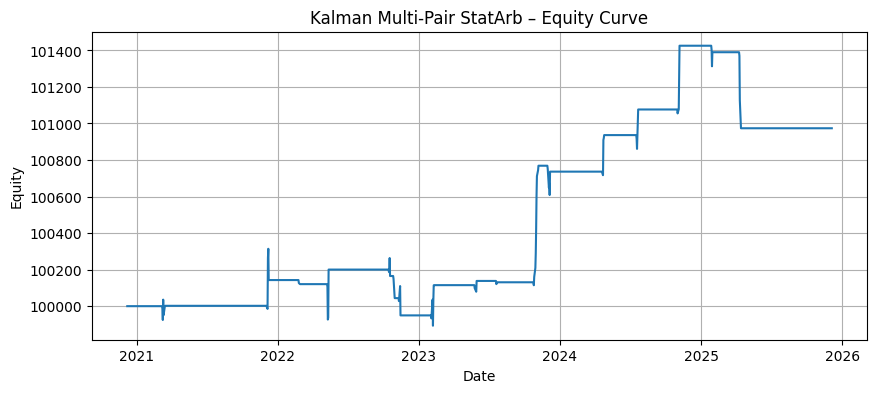

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(portfolio_df.index, portfolio_df["equity"])
plt.title("Kalman Multi-Pair StatArb – Equity Curve")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.grid(True)
plt.show()
